In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

# load python modules
SRC_PATH = '/Users/tabea/Documents/UrbanMobility/src'
import sys
sys.path.append(SRC_PATH)
from models_ml_dl import tree_models as tree_models
from visualization import model_evaluation as eval
from visualization import model_interpretation as interpret

# 1. Interpretability: Random Forest

### 1.1 Data & Model Loading: Tree-based Models

In [2]:
journey_daily_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2016.csv', parse_dates=['start_date'], index_col=0)
journey_daily_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2017.csv', parse_dates=['start_date'], index_col=0)
journey_daily_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2018.csv', parse_dates=['start_date'], index_col=0)
journey_daily_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_daily_train = pd.concat([journey_daily_16, journey_daily_17, journey_daily_18])
journey_daily_test = journey_daily_19.copy()

# train test split
x_daily_train, y_daily_train, x_daily_test, y_daily_test = tree_models.train_test_split(journey_daily_train, journey_daily_test)

In [3]:
#load model
rf_daily = joblib.load('../models/random_forest_daily.pkl')
gb_daily = joblib.load('../models/random_forest_daily.pkl')

#pred
feature_cols_daily = x_daily_train.columns.drop(['start_date', 'hour']) 
y_pred_rf = rf_daily.predict(x_daily_test[feature_cols_daily])
y_pred_gb = gb_daily.predict(x_daily_test[feature_cols_daily])

### 1.2 Accumulated Local Effects Plot: Random Forest

In [ ]:
from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt

# ALE
ale = ALE(rf_daily.predict, feature_names=feature_cols_daily, target_names=['demand'])

# Convert DataFrame to numpy array, ensure columns match feature_names
x_daily_test_np = x_daily_test[feature_cols_daily].to_numpy()

# Generate the explanation with numpy array
ale_exp = ale.explain(x_daily_test_np)

In [68]:
x_daily_test[feature_cols_daily].columns

Index(['day_of_week', 'is_weekend', 'part_of_day', 'month', 'season', 'bank_holiday', 'tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours', 'day_of_month', 'day_of_year', 'bike_station_counts', 'bike_docks_counts', 'population_density', 'age_mean', 'age_25_percentile', 'age_75_percentile', 'female_ratio', 'householdsize_1_ratio', 'householdsize_2_ratio', 'householdsize_3-5_ratio', 'householdsize_6+_ratio', 'ethnic_asian_ratio', 'ethnic_african_caribbean_ratio', 'ethnic_mixed_ratio', 'ethnic_white_ratio', 'ethnic_arab_other_ratio', 'religion_no_ratio', 'religion_christian_ratio', 'religion_buddhist_ratio', 'religion_hindu_ratio', 'religion_jewish_ratio', 'religion_muslim_ratio', 'religion_sikh_ratio', 'highes_education_no_ratio', 'highes_education_l1_ratio', 'highes_education_l2_ratio', 'highes_education_apprenticeship_ratio', 'highes_education_l3_ratio', 'highes_education_l4_ratio',
       'hea

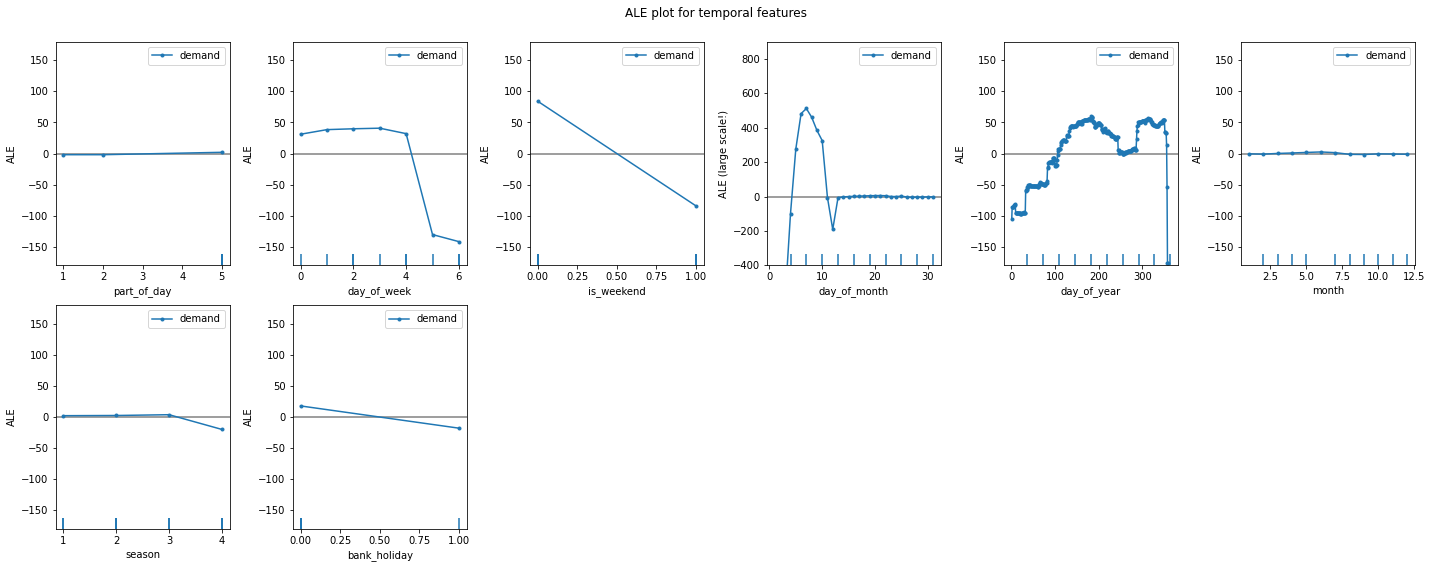

In [117]:
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('day_of_month')]

temporal_features = ['part_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'day_of_year', 'month', 'season', 'bank_holiday']
interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp, temporal_features, 8, 0.92, 'temporal features', large_scale_index)

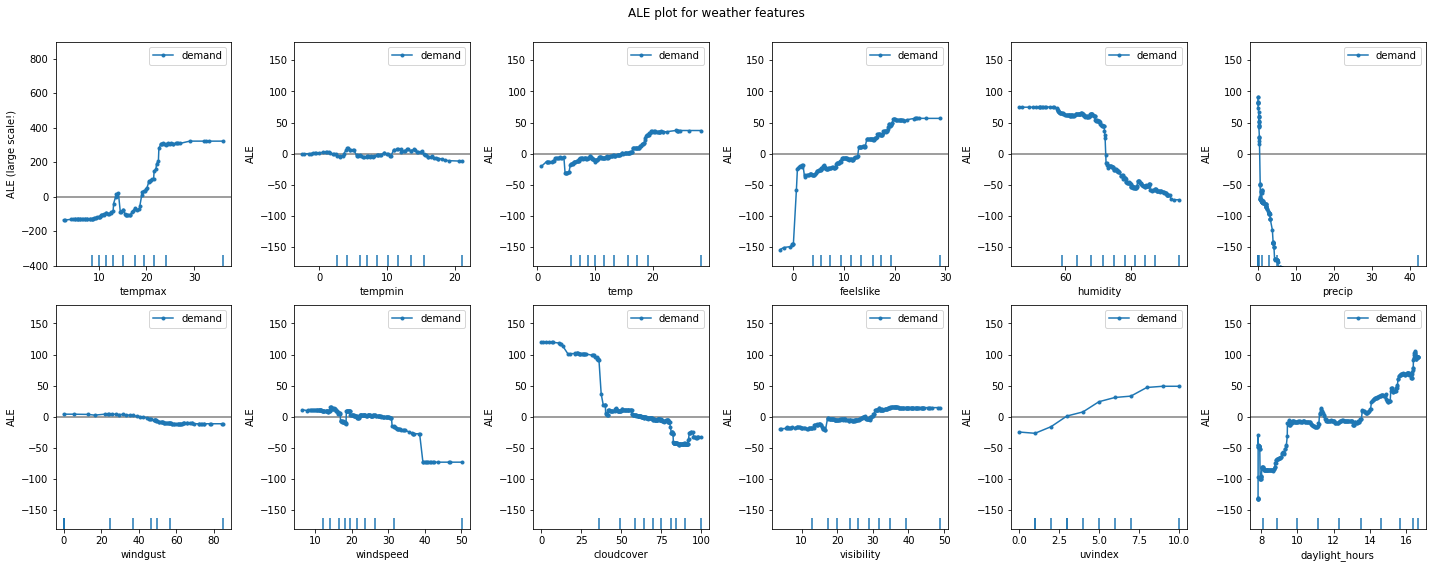

In [116]:
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('tempmax')]

weather_features = ['tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours']
interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp, weather_features, 8, 0.92, 'weather features', large_scale_index)

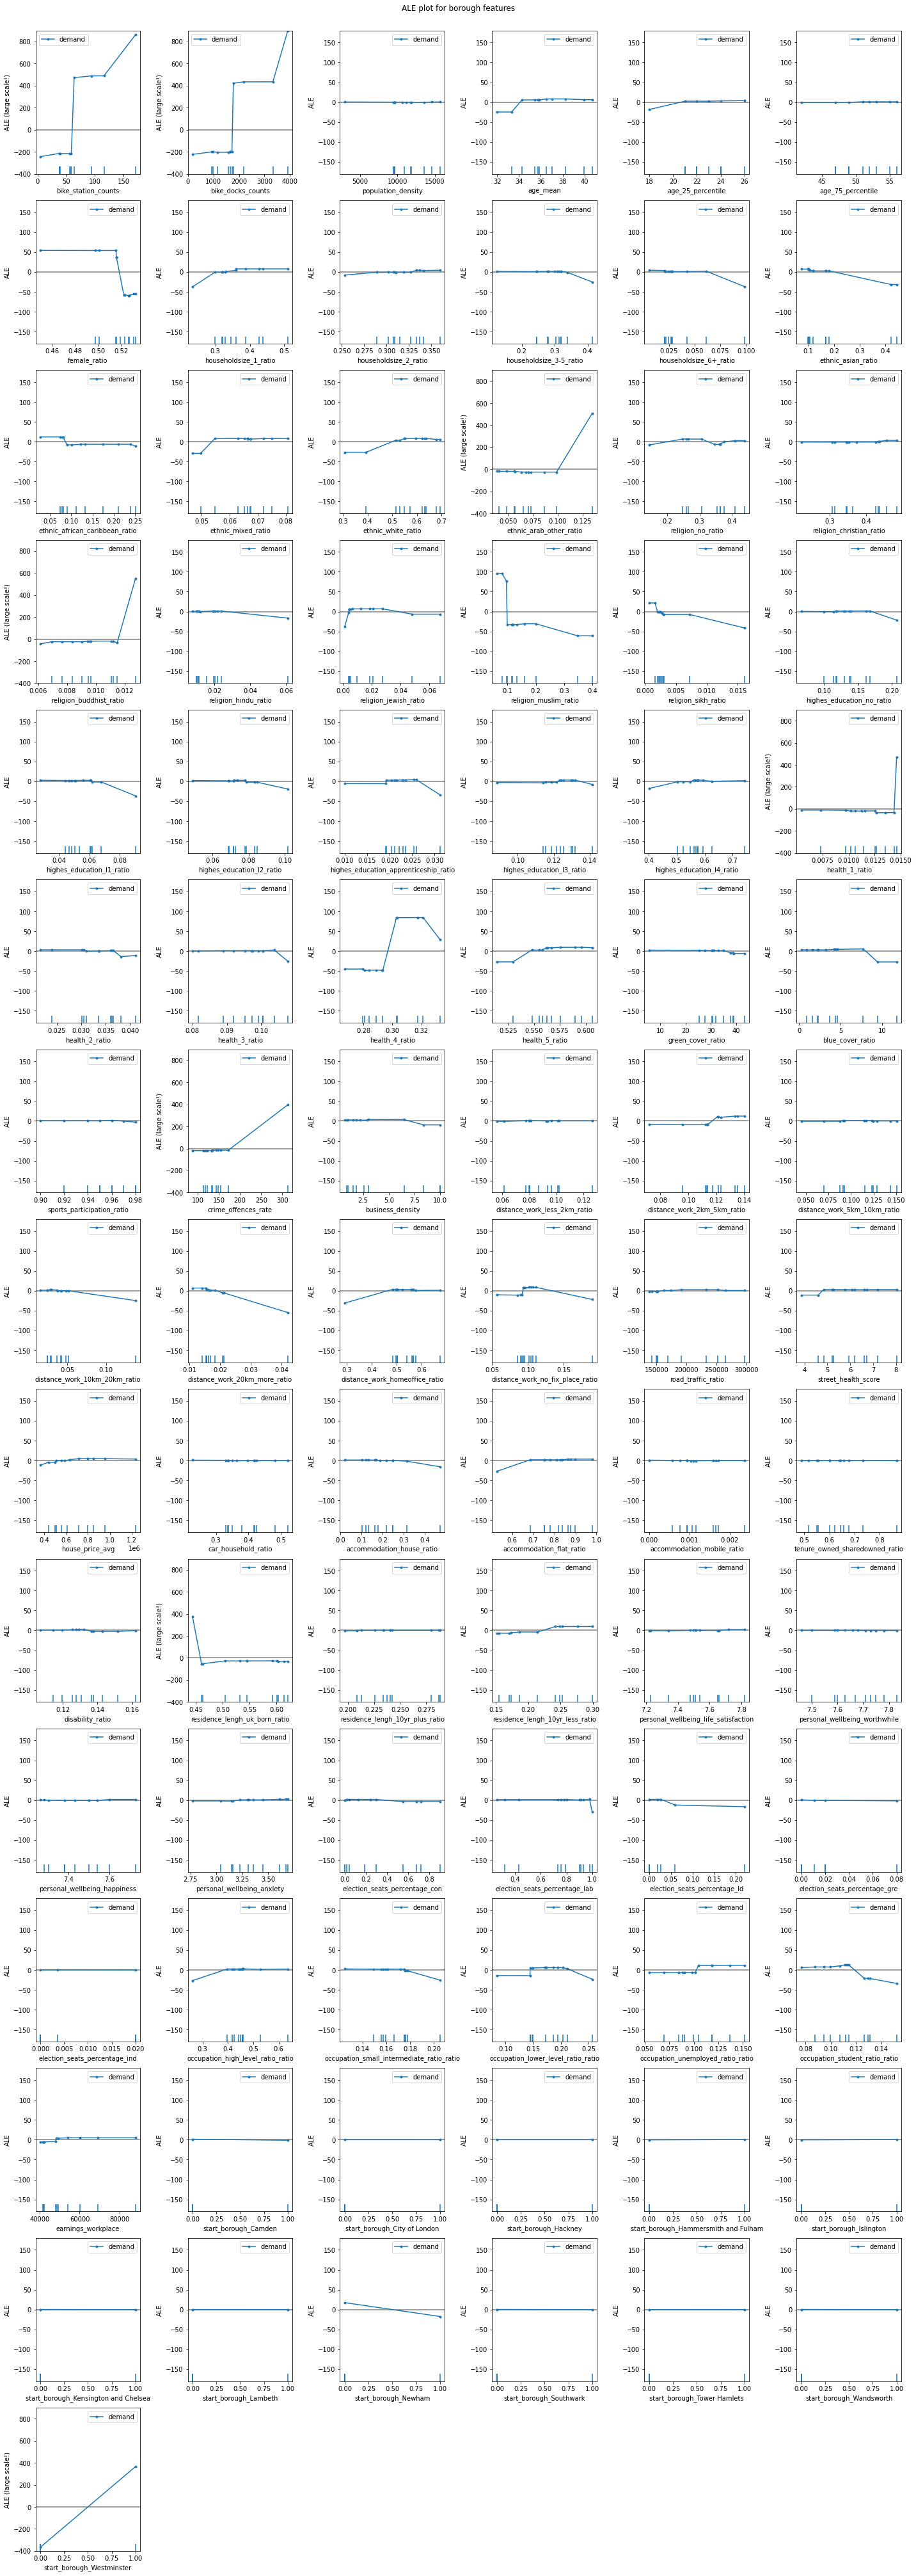

In [115]:
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('bike_station_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('bike_docks_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('ethnic_arab_other_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('religion_buddhist_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('health_1_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('start_borough_Westminster'),
                     x_daily_test[feature_cols_daily].columns.get_loc('residence_lengh_uk_born_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('crime_offences_rate')
                     ]

borough_features = x_daily_test[feature_cols_daily].columns[~x_daily_test[feature_cols_daily].columns.isin(temporal_features) & ~x_daily_test[feature_cols_daily].columns.isin(weather_features)]
interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp, borough_features, 57, 0.97, 'borough features', large_scale_index)

In [ ]:
# Comparing ALE for Random Forest and Gradient Boosting for all the features

### 1.3 Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
permutation = permutation_importance(rf_daily, x_daily_test[feature_cols_daily], y_daily_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_importance = permutation.importances_mean

In [122]:
# Combine feature names and importances into a list of tuples
feature_importances = [(name, importance) for name, importance in zip(x_daily_test[feature_cols_daily].columns, perm_importance)]

# Sort the feature importances by the importance score
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Display the feature importances
for name, importance in feature_importances:
    print(f"Feature: {name}, Score: {importance}")


Feature: day_of_month, Score: 0.16398126037054697
Feature: bike_station_counts, Score: 0.10349984373950716
Feature: bike_docks_counts, Score: 0.09240961366631692
Feature: tempmax, Score: 0.07407839832765557
Feature: religion_buddhist_ratio, Score: 0.018262853935556156
Feature: start_borough_Westminster, Score: 0.01700651756681155
Feature: precip, Score: 0.015972936447325847
Feature: day_of_week, Score: 0.014260590435138498
Feature: ethnic_arab_other_ratio, Score: 0.014239738735886642
Feature: is_weekend, Score: 0.013811836658339783
Feature: health_1_ratio, Score: 0.012731013376326117
Feature: residence_lengh_uk_born_ratio, Score: 0.008259043878537865
Feature: crime_offences_rate, Score: 0.007596739900118399
Feature: day_of_year, Score: 0.005360070768957592
Feature: humidity, Score: 0.0038347591307698937
Feature: religion_sikh_ratio, Score: 0.003481009696540882
Feature: religion_muslim_ratio, Score: 0.002509373150817873
Feature: health_4_ratio, Score: 0.0021752470738508833
Feature: fema

### 1.4 Shapley Additive Explanations (SHAP)

In [4]:
# Create the explainer
explainer = shap.TreeExplainer(rf_daily)
expected_value = explainer.expected_value

# Compute SHAP values
shap_values = explainer(x_daily_test[feature_cols_daily])

In [139]:
# save explainer and values

filename_expl = '../models/shap_explainer_rf.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))

filename = '../models/shap_values_rf.sav'
pickle.dump(shap_values, open(filename, 'wb'))

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Text(0.5, 1.0, 'SHAP Bar Plot - Global Feature Importance')

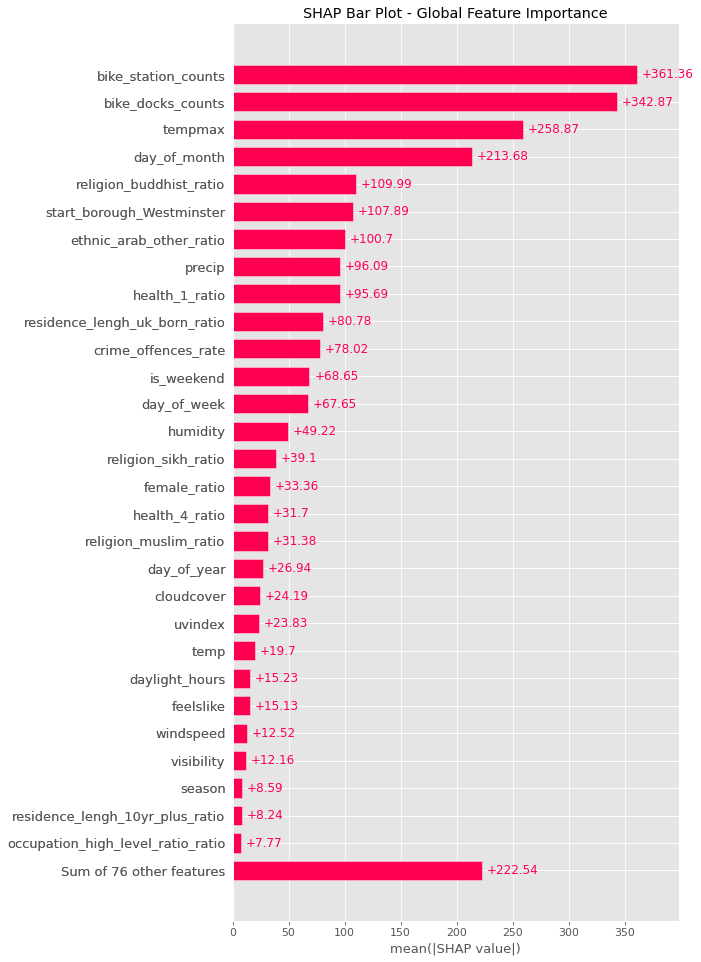

In [14]:
# bar plot: global feature importance plot. Uses global absolute mean

shap.plots.bar(shap_values, max_display=30, show=False)
plt.title("SHAP Bar Plot - Global Feature Importance")

700 957


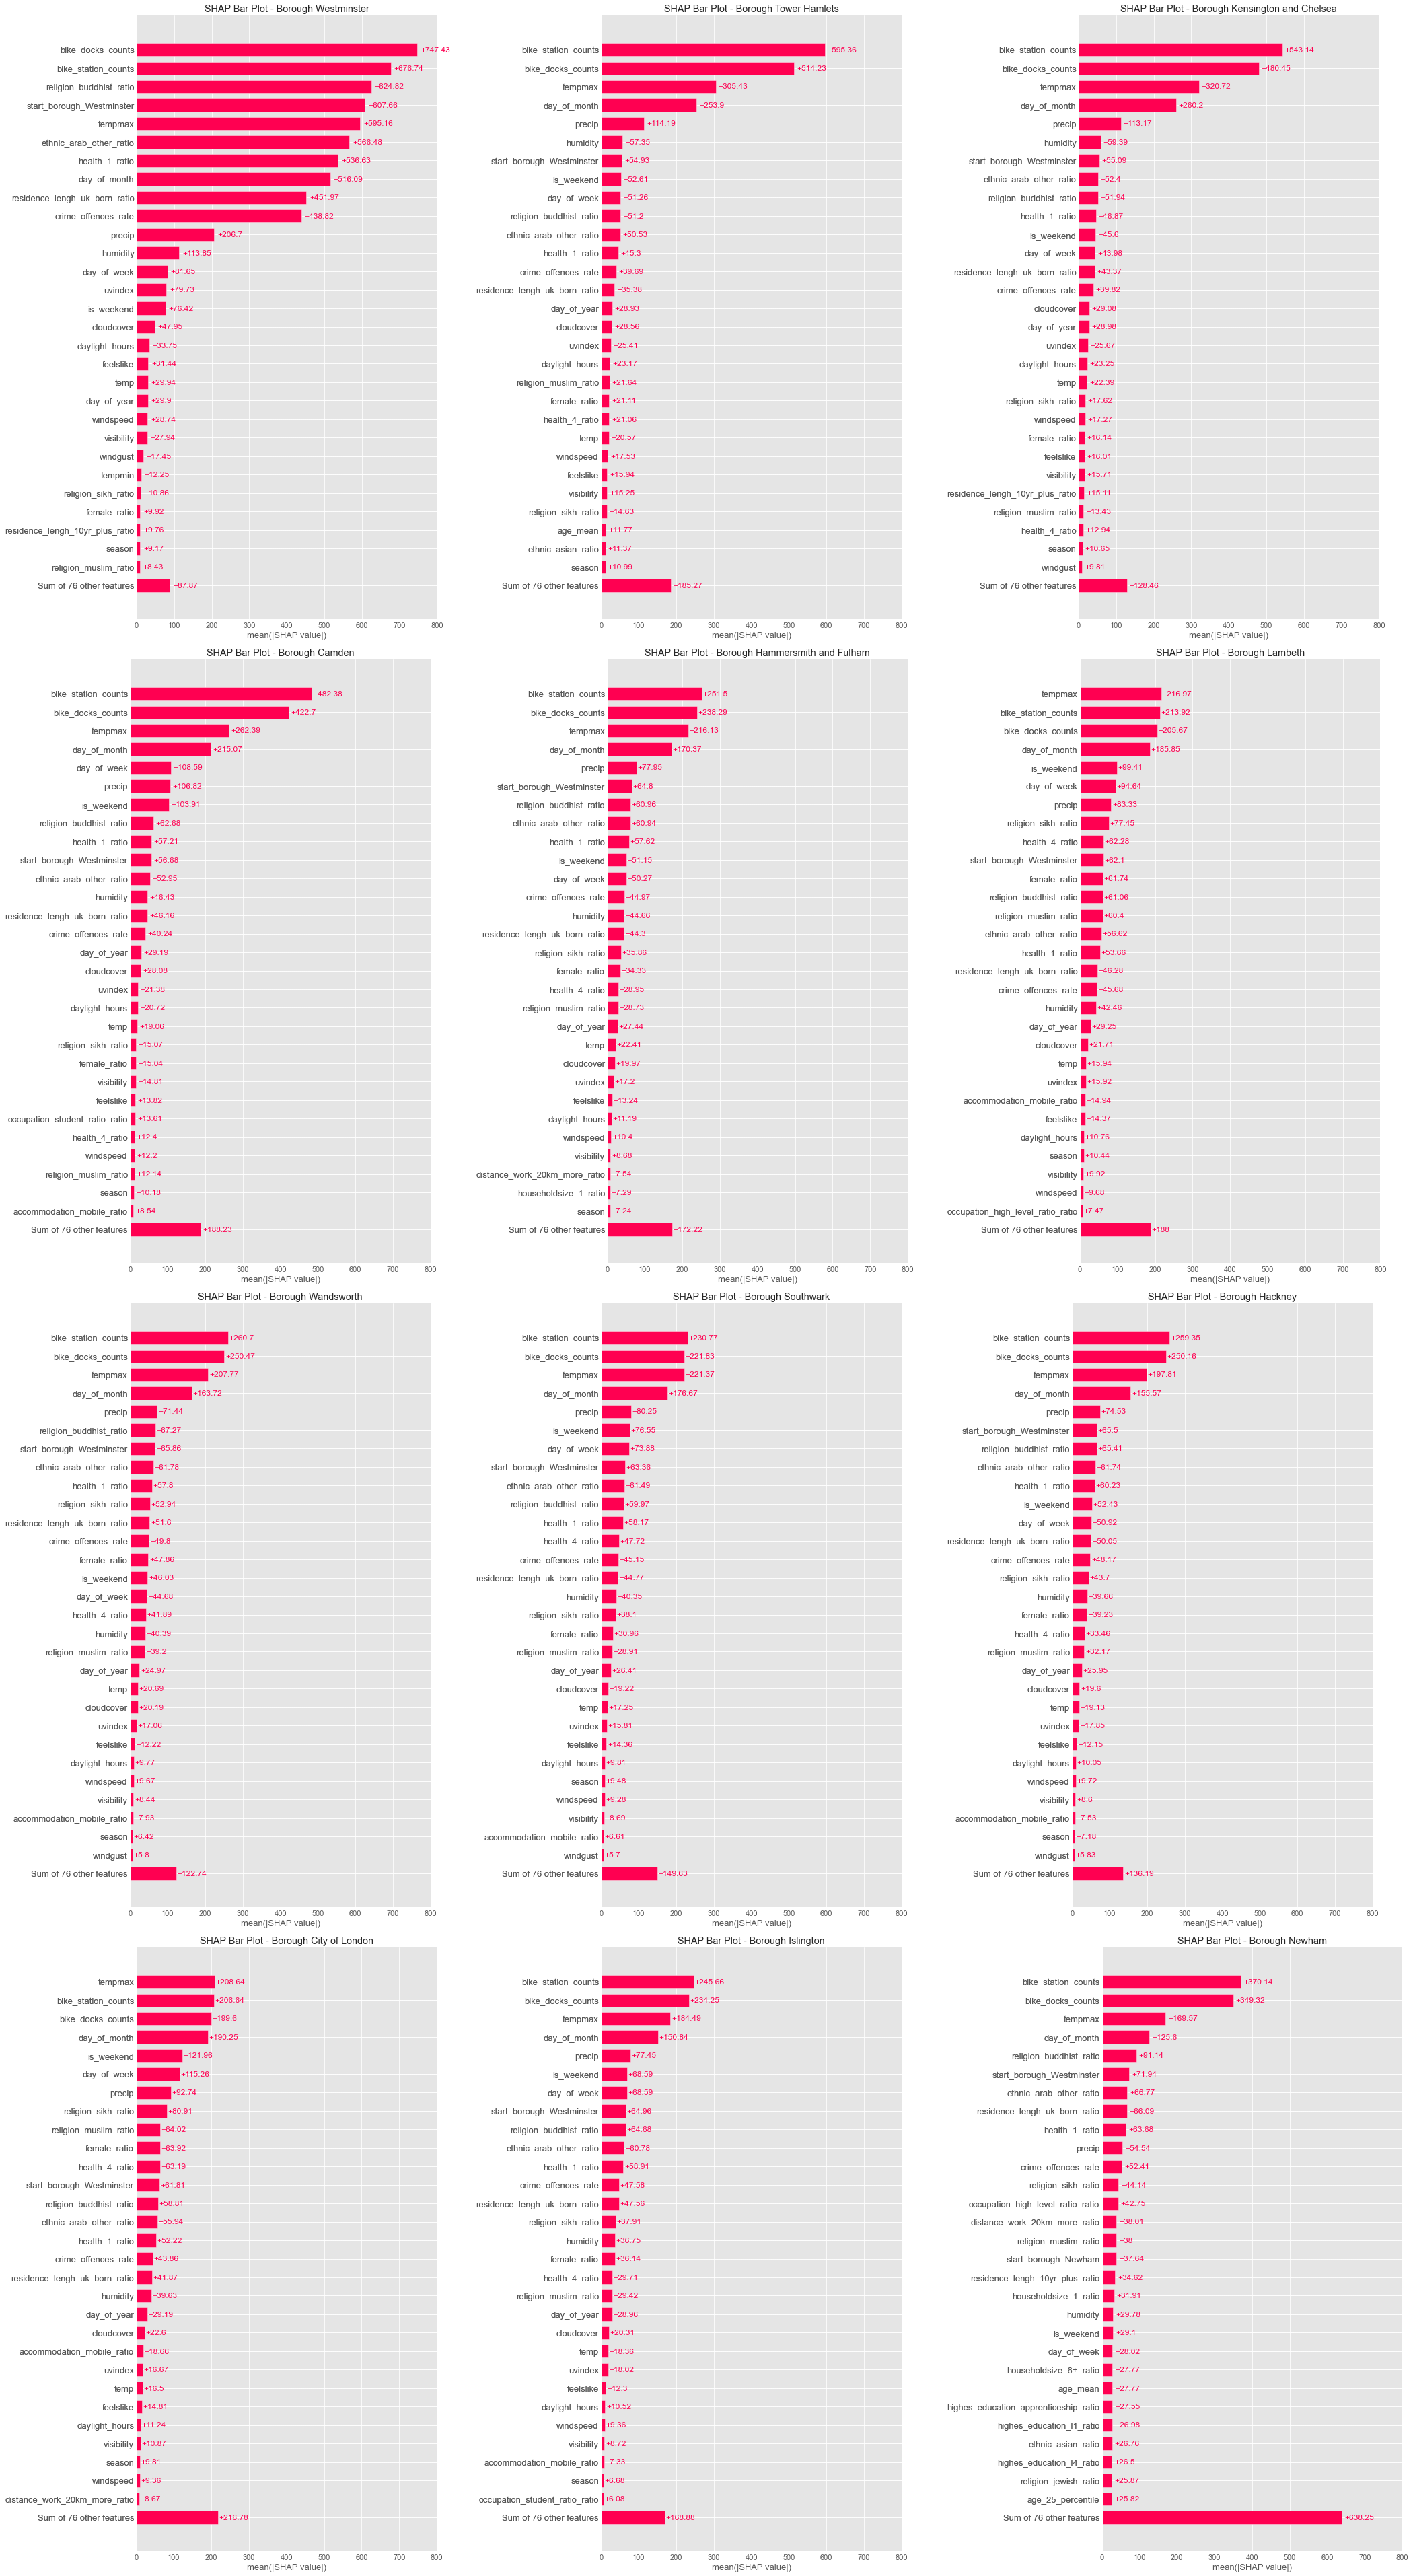

<Figure size 576x1188 with 0 Axes>

In [131]:
# small multiplies bar plot per borough

boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 
            'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

# Get the indices in the shap_values where each borough is true
borough_indices = {borough: np.where(x_daily_test['start_borough_' + borough] == 1)[0] for borough in boroughs}

# Calculate the global min and max SHAP values
global_min = 0
global_max = 800

for i, (borough, indices) in enumerate(borough_indices.items()):
    # Select only the rows for this borough
    borough_shap_values = shap_values[indices]
    
    # Plot the bar plot for this borough
    shap.plots.bar(borough_shap_values, max_display=30, show=False)
    plt.title(f"SHAP Bar Plot - Borough {borough}")

    # Set x limits
    plt.xlim(global_min, global_max)
    
    # Save the plot as a PNG
    plt.savefig(f'../reports/figures/shap_bar_plots/{borough}_shap_plot.png', bbox_inches='tight')
    
    # Clear the current plot to make room for the next one
    plt.clf()



# Open all the images
images = [Image.open(f'../reports/figures/shap_bar_plots/{borough}_shap_plot.png') for borough in boroughs]

# Number of images per row
n_cols = 3

# Calculate the number of rows
n_rows = len(boroughs) // n_cols
n_rows += len(boroughs) % n_cols

# Calculate the max width and height
max_width = max(image.width for image in images)
max_height = max(image.height for image in images)

print(max_width,max_height )

# Create a new image with the right size and white background
new_image = Image.new('RGB', (max_width * n_cols, max_height * n_rows), 'white')


# Paste each image next to each other
x_offset = 0
y_offset = 0
for i, image in enumerate(images):
    new_image.paste(image, (x_offset, y_offset))
    if (i+1) % n_cols == 0:  # Move to next row after every n_cols images
        y_offset += max_height
        x_offset = 0
    else:
        x_offset += max_width

# Save the final image
new_image.save('../reports/figures/shap_bar_plots/combined_shap_plots.png')
display(new_image)

tempmax: as the feature values increase, the shap value also increase
day of year: as the feature value increase, the shap value decreses -> negative impact of demand

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'SHAP Beeswarm Plot - Feature Impact on Output')

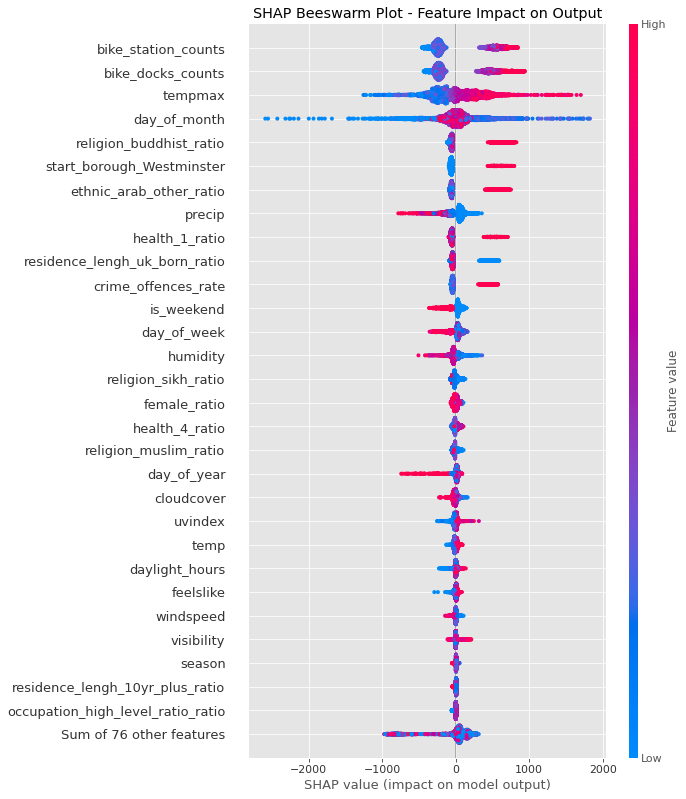

In [8]:
# beeswarm summary

shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.title("SHAP Beeswarm Plot - Feature Impact on Output")

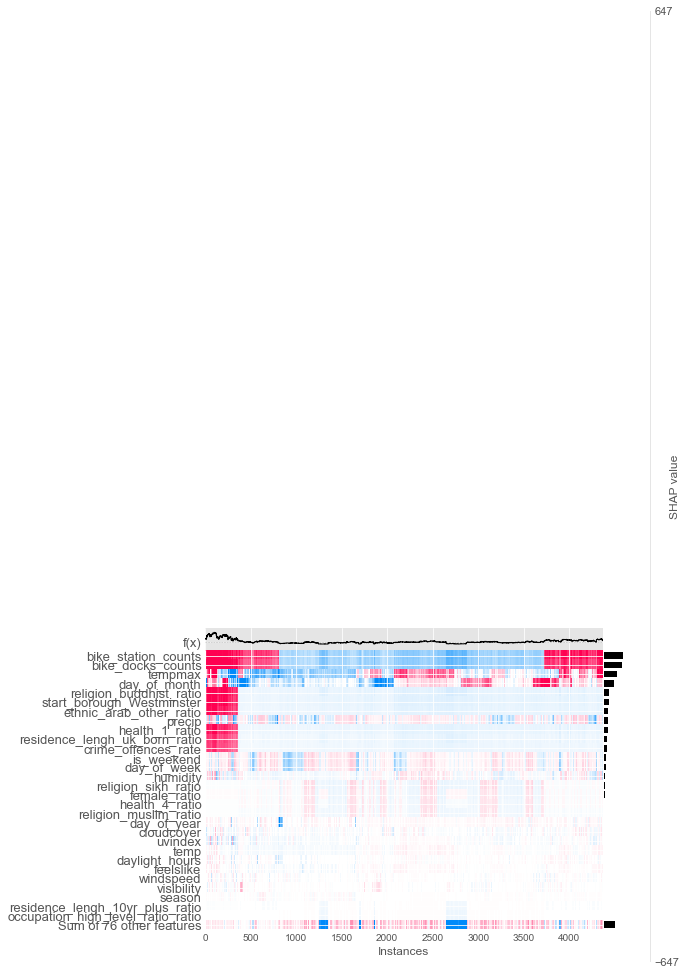

Text(0.5, 1.0, 'SHAP Heatmap Plot')

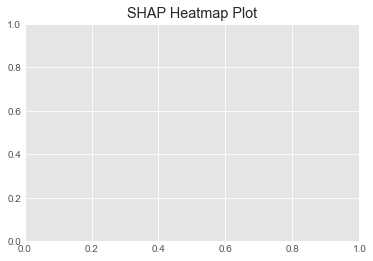

In [19]:
# heatmap
shap.plots.heatmap(shap_values, max_display=30, show=False)
plt.title("SHAP Heatmap Plot")

# x-axis: instances
# y-axis: features
# color scale: SHAP values
# f(x): output of model
# bar charts: global feature importance

In [103]:
print('Shape of shap_values:', shap_values.shape)
print('Shape of data:', x_daily_test[feature_cols_daily].shape)
print(feature_name in x_daily_test[feature_cols_daily].columns)


Shape of shap_values: (4368, 105)
Shape of data: (4368, 105)
True


# 2. Interpretability: Gradient Boosting

# 3. Interpretability: Deep Learning

### Data & Model Loading: Deep Learning